In [0]:
from google.colab import drive
drive.mount('/content/gdrive/')

In [0]:
!pip install tensorflow-gpu==2.0.0-rc1

# 검증 세트 나누고 전처리 과정 배우기  
  
## 하이퍼 파라미터(Hyperparameter)
* 매개변수의 값은 가중치나 절편처럼 알아서 학습되는 것이 아니라 사용자가 직접 선택하는 것이다. 이러한 사용자가 직접 설정하는 값을 하이퍼 파라미터 라고 한다.

## SVM(Support Vertor Machine:선형 서포트 벡터 머신)
* 훈련데이터의 클래스를 구분하는 경계선을 찾는 작업

## 모델 튜닝
* 성능에 만족을 걷기 위해서 매개변수의 값을 바꾸는 것

## 테스트 세트
* 실전에 투입된 모델의 성능을 측정하기 위해 서용
* 테스트 세트로 모델을 튜닝하면, 테스트 세트에 대해서만 좋은 성능을 내는 모델이 만들어 질 수 있다
* 이를 '테스트 세트의 정보가 모델에 새어 나갔다' 고 한다. 즉, 모델의 일반화 성능(generalization performance)이 왜곡된다.
* 테스트 세트는 모델 튜닝을 모두 마치고 마지막에 한번만 하는것이 좋다

## 검증 세트(Validation set)
* 모델을 튜닝하는 중에 성능을 확인하기 위해 필요한 데이터는 검증 세트이다.





In [0]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDClassifier
import matplotlib.pyplot as plt
import numpy as np

In [0]:
cancer = load_breast_cancer()
x = cancer.data
y = cancer.target
x_train_all, x_test, y_train_all, y_test = train_test_split(x,y,stratify=y, test_size=0.2, random_state=42)

* 이번 예제는 8:2로 나눈 데이터에서 다시 테스트를 8:2로 나눈다.

In [0]:
x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)
print(len(x_train), len(x_val))

364 91


# 데이터가 너무 적은 경우
* 데이터가 너무 적다면 검증 세트를 나누지 않고 교차 검증(cross validation)이라는 방법을 사용한다.
* 일반적으로 10만개의 자료가 있다면 8:1:1로 나누며 100 만개 이상의 데이터는 98:1:1로 나눈다.
* 검증과 테스트 세트의 샘플 수를 1만 개 이상 확보할 수 있다면 훈련 데이터에 많은 샘플을 할당 하는 것이 좋다.

# 데이터 전처리(data preprocessing)
* 잘 정리된 데이터도 전처리가 필요한 경우가 있는데 이는 데이터 특성의 스케일이 다른 경우이다

## 데이터 특성의 스케일(data scale)
* 어떤 특성이 가지고 있는 값의 범위
* 경사 하강법은 스케일에 민감한 알고리즘으로 특성의 스케일을 맞추는 전처리가 필요하다.


# 훈련데이터의 특성 확인

['mean perimeter' 'mean area']


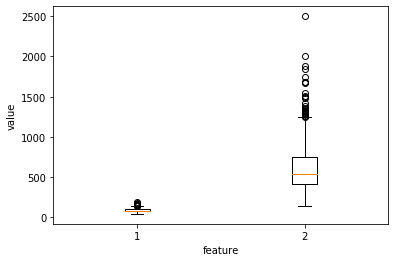

In [0]:
print(cancer.feature_names[[2,3]])
plt.boxplot(x_train[:, 2:4])
plt.xlabel('feature')
plt.ylabel('value')
plt.show()

# 가중치를 기록할 변수와 하이퍼 파리미터 추가 & 가중치 기록하고 업데이트 양 조절
* learning rate는 하이퍼 파리미터 이며, 학습률을 의미한다.
* 가중치의 업데이트 양을 조절하는 역확을 하며, 일반적으로 손실 함수는 복잡한 굴곡을 가진 다차원 공간의 초평면(hyperplane)이다.
* 만약 가중치를 큰 폭으로 업데이트하여 손실 함수가 최소가 될 수 있는 지점인 전역 최솟값을 지나쳐 버리게 되면, 최적의 해(최적의 가중치와 절편)를 구할 수가 없다.
* 따라서 전역 최솟값을 놓치치 않도록 가중치의 업데이트 양을 조절할 필요가 있다.

In [0]:
class SingleLayer:
    
    def __init__(self, learning_rate = 0.1):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b  # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err    # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a

    def update_val_loss(self, x_val, y_val):
        if x_val is None:
          return
        val_loss = 0
        for i in range(len(x_val)):
          z = self.forpass(x_val[i])
          a = self.activation(z)
          a = np.clip(a, 1e-10, 1-1e-10)
          val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val))
        
    def fit(self, x, y, epochs=100, x_val = None, y_val = None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                self.w -= self.lr*w_grad                  # 가중치 업데이트(학습률 적용)
                self.b -= b_grad                   # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y))
            # 검증 데이터에 대한 손실을 계산한다.
            self.update_val_loss(x_val, y_val)
    
    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) > 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [0]:
layer1 = SingleLayer()
layer1.fit(x_train, y_train)
layer1.score(x_val, y_val)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: overflow encountered in exp


0.8791208791208791

# 가중치 확인
* w_history안에는 100번의 epoch동안 변경된 가중치가 모두 저장되어 있다.
* 이중 3,4번째(w[2], w[3]) 값은 각각 mean perimeter, mean area특성에 대한 가중치이다.
* w3에 대한 그래디언트가 크기 때문에 w3 축을따라 가중치가 크게 요동치고 있다.
* 즉 가중치의 최적값에 도달하는 동안 w3값이 크게 요동치므로 모델이 불안정하게 수렴한다는 것을 알 수 있다.
* 이는 스케일 조정으로 해결할 수 있다.


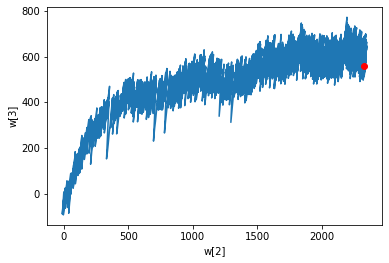

In [0]:
w2=[]
w3=[]
for w in layer1.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

# 스케일 조정
## 표준화(standardization)
* z = x-m/s
* 특성값에서 평균을 빼고 표준편차로 나누면된다.
* 표준화를 하면 평균이 0이고, 분산이 1인 특성이 만들어진다.

### 표준편차
* 표준편차는 데이터가 얼마나 흩어져 있는지를 나타내는 지표로, 분산(variance)의 제곱근이다.


# 표준화 구현
* 넘파이의 mean() 과 std()는 axis에 0을 넣어주면 2차원 배열의 열을 기준으로 통계치를 계산하여 하나의 행 벡터로 반환한다.

In [0]:
train_mean = np.mean(x_train, axis=0)
train_std = np.std(x_train, axis=0)
x_train_scaled = (x_train - train_mean)/train_std

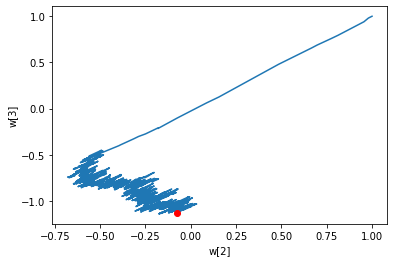

In [0]:
layer2 = SingleLayer()
layer2.fit(x_train_scaled, y_train)
w2 = []
w3 = []
for w in layer2.w_history:
  w2.append(w[2])
  w3.append(w[3])
plt.plot(w2,w3)
plt.plot(w2[-1], w3[-1], 'ro')
plt.xlabel('w[2]')
plt.ylabel('w[3]')
plt.show()

* x_val은 표준화를 하지 않아 데이터의 스케일이 다르다. 따라서 Acc가 낮게 나온다.

In [0]:
layer2.score(x_val, y_val)

0.37362637362637363

In [0]:
val_mean = np.mean(x_val, axis=0)
val_std = np.std(x_val, axis=0)
x_val_scaled = (x_val - val_mean)/val_std
layer2.score(x_val_scaled, y_val)

0.967032967032967

# 훈련 데이터와 검증 데이터의 스케일 조정이 다른 비율로 된경우
* 원본 데이터의 산점도

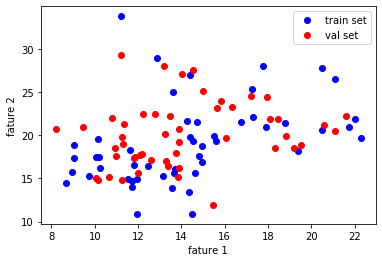

In [0]:
plt.plot(x_train[:50,0], x_train[:50,1],'bo')
plt.plot(x_val[:50, 0], x_val[:50,1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val set'])
plt.show()

* 전처리 데이터의 산점도

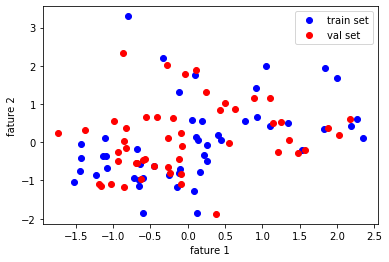

In [0]:
plt.plot(x_train_scaled[:50,0], x_train_scaled[:50,1],'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val set'])
plt.show()

* 두 그래프를 보면 훈련 데이터와 검증 데이터가 다른 비율로 표준화된 것을 볼 수 있다.
* 원본 훈련 데이터와 원본 검증 데이터의 그래프에서의 거리는 변환후에도 같아야 한다.
* 따라서 같은 비율로 표준화를 해야한다.

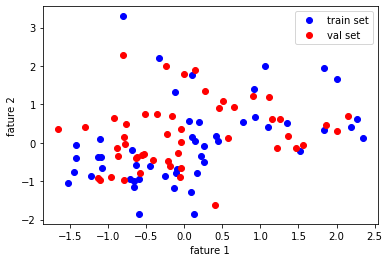

In [0]:
x_val_scaled = (x_val - train_mean)/train_std

plt.plot(x_train_scaled[:50,0], x_train_scaled[:50,1],'bo')
plt.plot(x_val_scaled[:50, 0], x_val_scaled[:50,1], 'ro')
plt.xlabel('fature 1')
plt.ylabel('fature 2')
plt.legend(['train set', 'val set'])
plt.show()

In [0]:
layer2.score(x_val_scaled, y_val)

0.967032967032967

# 과대 적합과 과소 적합
## 과대 적합 
* 모델이 훈련세트에서는 좋은 성능을 내지만 검증 세트에서는 낮은 성능을 내는 경우  
* 과대 적합된 모델을 분산이 크다(high variance)고 말한다
* 원인중 하나는 훈련 세트에 충분히 다양한 패턴의 샘플이 포함되지 않는 경우
* 더욱 많은 훈련 데이터를 모으면 이는 해결할 수 있는 문제이다.  
* 만약 데이터를 많이 모으기 힘들다면, 모델의 가중치를 제한 할 수 있다.(모델의 복잡도를 낮춘다)

## 과소 적합 
* 훈련 세트와 검증 세트의 성능 차이는 크지 않지만 모두 낮은 성능을 내는 경우
* 과소 적합된 모델을 편향이 크다(high bias)고 한다.
* 과소 적합은 충분히 모델이 복잡하지 않아서 훈련 데이터에 있는 패턴을 모두 잡지 못하는 경우이다.
* 복잡도가 더 높은 모델을 사용하거나, 가중치의 규제를 완화하면 이를 해결할 수 있다.

## 모델 복잡도
* 모델이 가지는 학습 가능한 가중치의 개수, 층이나 유닛의 개수가 많아지면 복잡도가 높은 모델이 만들어진다.


## 적절한 편향-분산 트레이드오프 선택
* 과소적합된 모델(편향)과 과대적합된 모델(분산) 사이의 관계를 편향-분산 트레이드오프(bias-varience tradeoff)라고 한다.
* 편향-분산 트레이드오프란 편향을 줄이면(훈련세트의 성능을 높이면) 분산이 커지고(검증 세트와 성능 차이가 커지고) 반대로 분산을 줄이면(검증 세트와 성능 차이를 줄이면) 편향이 커지는(훈련 세트의 성능이 낮아진다)것을 말한다.

In [0]:
layer3 = SingleLayer()
layer3.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val = y_val)

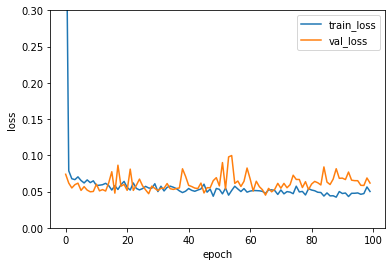

In [0]:
plt.ylim(0, 0.3)
plt.plot(layer3.losses)
plt.plot(layer3.val_losses)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [0]:
layer4 = SingleLayer()
layer4.fit(x_train_scaled, y_train, epochs=18)
layer4.score(x_val_scaled, y_val)

0.978021978021978

# 규제 방법
* 가중치 규제란 가중치의 값이 커지지 않도록 제한하는 방법이다. 가중치를 규제하면 모델의 일반회된 성능이 높아진다.
* 모델이 몇개의 데이터에 집착하면 새로운 데이터에 적응을 못하므로 좋은 성능을 가졌다고 할 수 없다.

# L1규제
* 손실 함수에 가중치의 절댓값인 L1노름(norm)을 추가한다.
* L1노름의 n은 가중치의 개수를 의미하므로, L1규제를 가중치의 절댓값을 손실 함수에 더한것으로 보아도 된다.
* 손실 함수에 L1 노름을 더하면 L1규제가 만들어 진다. 이때 L1노름을 그냥 더하지 않고 alpha값을 곱해서 더하는데 alpha값은 규제의 양을 조절하는 하이퍼 파라미터이다.
* alpha값이 커지면 전체 손실 함수의 값이 커지지 않도록 가중치의 합이 작아져야 한다 (규제가 강해졌다 --> 가중치가 작아졌으므로)
* alpha의 값이 작아지면 손실 함수의 값이 커지므로 규제가 약해졌다고 한다.
* 절편에 대해 규제를 하지 않는 이유는 절편은 모델에 영향을 미치는 방식이 가중치와 달라서 이다. 절편을 규제하면 모델을 어떤 방향으로 이동시킬 뿐 복잡도에는 영향을 주지 않는다.
* 회귀 모델에 L1규제를 적용 --> 라쏘(Lasso)
* 라쏘는 가중치를 줄이다 못해 0으로 만들 수도 있다. 가중치가 0인 특성은 모델에서 사용할 수 없다는 것과 같다. 즉 특성을 선택할 수 있다는 효과를 얻을 수 있다.
* L1규제는 하이퍼 파라미터인 alpha에 많이 의존한다. 즉 가중치의 크기에 따라 규제의 양이 변하지 않으므로 규제효과가 좋지 않다.

# L2규제
* 손실 함수에 L2노름의 제곱을 더하면 L2규재이다.
* alpha는 규제의 양을 조절하기 위한 하이퍼 파라미터 이다.
* L2규제를 미분하면 간단히 가중치 벡터인 w만 남는다.
* L2규제는 그레디언트 계산에 가중치의 값 자체가 포함되므로 가중치의 부호만 사용하는 L1규제 보다 조금 더 효과적이다.
* L2규제는 가중치를 완전히 0으로 만들지 않는다. 가중치를 0으로 만들면 특성을 제외하는 효과는 있지만, 모델의 복잡도가 떨어진다.
* 회귀 모델에 L2규제를 적용하면 릿지(Ridge)가 된다.

In [0]:
# 규제 추가 모델
class SingleLayer:
    
    def __init__(self, learning_rate = 0.1, l1=0, l2=0):
        self.w = None
        self.b = None
        self.losses = []
        self.val_losses = []
        self.w_history = []
        self.lr = learning_rate
        self.l1=l1
        self.l2=l2

    def forpass(self, x):
        z = np.sum(x * self.w) + self.b  # 직선 방정식을 계산합니다
        return z

    def backprop(self, x, err):
        w_grad = x * err    # 가중치에 대한 그래디언트를 계산합니다
        b_grad = 1 * err    # 절편에 대한 그래디언트를 계산합니다
        return w_grad, b_grad

    def activation(self, z):
        a = 1 / (1 + np.exp(-z))  # 시그모이드 계산
        return a

    def update_val_loss(self, x_val, y_val):
        if x_val is None:
          return
        val_loss = 0
        for i in range(len(x_val)):
          z = self.forpass(x_val[i])
          a = self.activation(z)
          a = np.clip(a, 1e-10, 1-1e-10)
          val_loss += -(y_val[i]*np.log(a)+(1-y_val[i])*np.log(1-a))
        self.val_losses.append(val_loss/len(y_val) + self.reg_loss())
        
    def fit(self, x, y, epochs=100, x_val = None, y_val = None):
        self.w = np.ones(x.shape[1])               # 가중치를 초기화합니다.
        self.b = 0                                 # 절편을 초기화합니다.
        self.w_history.append(self.w.copy())       # 가중치를 기록합니다.
        for i in range(epochs):                    # epochs만큼 반복합니다
            loss = 0
            # 인덱스를 섞습니다
            indexes = np.random.permutation(np.arange(len(x)))
            for i in indexes:                      # 모든 샘플에 대해 반복합니다
                z = self.forpass(x[i])             # 정방향 계산
                a = self.activation(z)             # 활성화 함수 적용
                err = -(y[i] - a)                  # 오차 계산
                w_grad, b_grad = self.backprop(x[i], err) # 역방향 계산
                w_grad+=self.l1*np.sign(self.w) + self.l2*self.w
                self.w -= self.lr*w_grad                  # 가중치 업데이트(학습률 적용)
                self.b -= b_grad                   # 절편 업데이트
                # 가중치를 기록합니다.
                self.w_history.append(self.w.copy())
                # 안전한 로그 계산을 위해 클리핑한 후 손실을 누적합니다
                a = np.clip(a, 1e-10, 1-1e-10)
                loss += -(y[i]*np.log(a)+(1-y[i])*np.log(1-a))
            # 에포크마다 평균 손실을 저장합니다
            self.losses.append(loss/len(y) + self.reg_loss())
            # 검증 데이터에 대한 손실을 계산한다.
            self.update_val_loss(x_val, y_val)
    
    def reg_loss(self):
      return self.l1*np.sum(np.abs(self.w)) + self.l2/2*np.sum(self.w**2)

    def predict(self, x):
        z = [self.forpass(x_i) for x_i in x]     # 정방향 계산
        return np.array(z) > 0                   # 스텝 함수 적용
    
    def score(self, x, y):
        return np.mean(self.predict(x) == y)

In [0]:
l1_list = [0.0001, 0.001, 0.01]

for l1 in l1_lsit:
  lyr = SingleLayer(l1=l1)
  lyr.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l1={})'.format(l1))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0,0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.titlw('weight (l1={})'.format(l1))
  plt.xlabel('weight')
  plt.ylabel('value')
  plt.ylim(-4,4)
  plt.show()

In [0]:
layer5 = SingleLayer(l1=0.001)
layer5.fit(x_train_scaled, y_train, epochs=20)
layer5.score(x_val_scaled, y_val)

In [0]:
l2_list = [0.0001, 0.001, 0.01]

for l2 in l2_list:
  lyr = SingleLayer(l2=l2)
  lyr.fit(x_train_scaled, y_train, x_val = x_val_scaled, y_val=y_val)

  plt.plot(lyr.losses)
  plt.plot(lyr.val_losses)
  plt.title('Learning Curve (l2={})'.format(l2))
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train_loss', 'val_loss'])
  plt.ylim(0,0.3)
  plt.show()

  plt.plot(lyr.w, 'bo')
  plt.titlw('weight (l2={})'.format(l2))
  plt.xlabel('weight')
  plt.ylabel('value')
  plt.ylim(-4,4)
  plt.show()

In [0]:
layer6 = SingleLayer(l2=0.01)
layer6.fit(x_train_scaled, y_train, epochs=50)
layer6.score(x_val_scaled, y_val)

* 가중치를 강하게 제한했기 때문에 검증 세트의 손실 값을 일정한 수준으로 유지하면서, 알고리즘이 전역 최솟값을 찾는 과정을 오래 반복할 수 있다.

In [0]:
np.sum(layer6.predict(x_val_scaled) == y_val)

# SGDClassifier에서 규제사용


In [0]:
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
sgd.fit(x_train_scaled, y_train)
sgd.score(x_val_scaled, y_val)

# K-폴드 교차 검증
* 훈련 세트를 동일한 크기의 폴드가 K개가 되도록 나눈다
* 각 폴드를 검증을 하기 위해 사용하고 나머지 폴드들은 훈련을 하기 위해 사용된다. 이 과정을 k번 반복하여 모델을 만든다.
* 코드에서 폴드를 나누기전 훈련 데이터를 전처리 한다면 이는 검증 데이터를 누설하는것이다. 검증 데이터를 나누고 나서 훈련 데이터를 전처리하는 것을 주의 해야 한다.

In [0]:
k = 10
bins = len(x_train_all)//k
validation_scores = []
for i in range(k):
  start = i*bins
  end = (i+1)*bins
  val_fold = x_train_all[start:end]
  val_target = y_train_all[start:end]
  train_index = list(range(0,start)) + list(range(end,len(x_train_all)))
  train_fold = x_train_all[train_index]
  train_target = y_train_all[train_index]

  train_mean = np.mean(train_fold, axis=0)
  train_std = np.std(train_fold, axis=0)
  train_fold_scaled = (train_fold-train_mean)/train_std
  val_fold_scaled = (val_fold-train_mean)/train_std

  lyr = SingleLayer(l2=0.01)
  lyr.fit(train_fold_scaled, train_target, epochs=50)
  score = lyr.score(val_fold_scaled, val_target)
  validation_scores.append(score)

print(np.mean(validation_scores))

0.9733333333333334


In [0]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate
sgd = SGDClassifier(loss='log', penalty='l2', alpha=0.001, random_state=42)
pipe = make_pipeline(StandardScaler(), sgd)
scores = cross_validate(pipe, x_train_all, y_train_all, cv=10, return_train_score=True)
print(np.mean(scores['test_score']))

0.9694202898550724


In [0]:
print(np.mean(scores['train_score']))

0.9875478561631581
